In [1]:
%config Completer.use_jedi = False

In [2]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX

import statsmodels.api as sm

### Load Data

In [3]:
# Import the data
dfTrain = pd.read_csv("data/DailyDelhiClimateTrain.csv")
dfTest = pd.read_csv("data/DailyDelhiClimateTest.csv")

### Check NULLs

In [4]:
dfTrain.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [5]:
dfTest.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

### Handle dates

In [6]:
dfTrain['date'] = pd.to_datetime(dfTrain['date'])

In [7]:
dfTest['date'] = pd.to_datetime(dfTest['date'])

In [8]:
dfTrain.dtypes

date            datetime64[ns]
meantemp               float64
humidity               float64
wind_speed             float64
meanpressure           float64
dtype: object

### Set date as index

In [9]:
# Set the date as index 
dfTrain = dfTrain.set_index('date')

In [10]:
# Set the date as index 
dfTest = dfTest.set_index('date')

In [11]:
# Select the proper time period for weekly aggreagation
dfTrainMS = dfTrain.resample('MS').mean()

In [12]:
dfTrainMS.drop(dfTrainMS.tail(1).index, inplace=True)

In [13]:
dfTestMS = dfTest.resample('MS').mean()

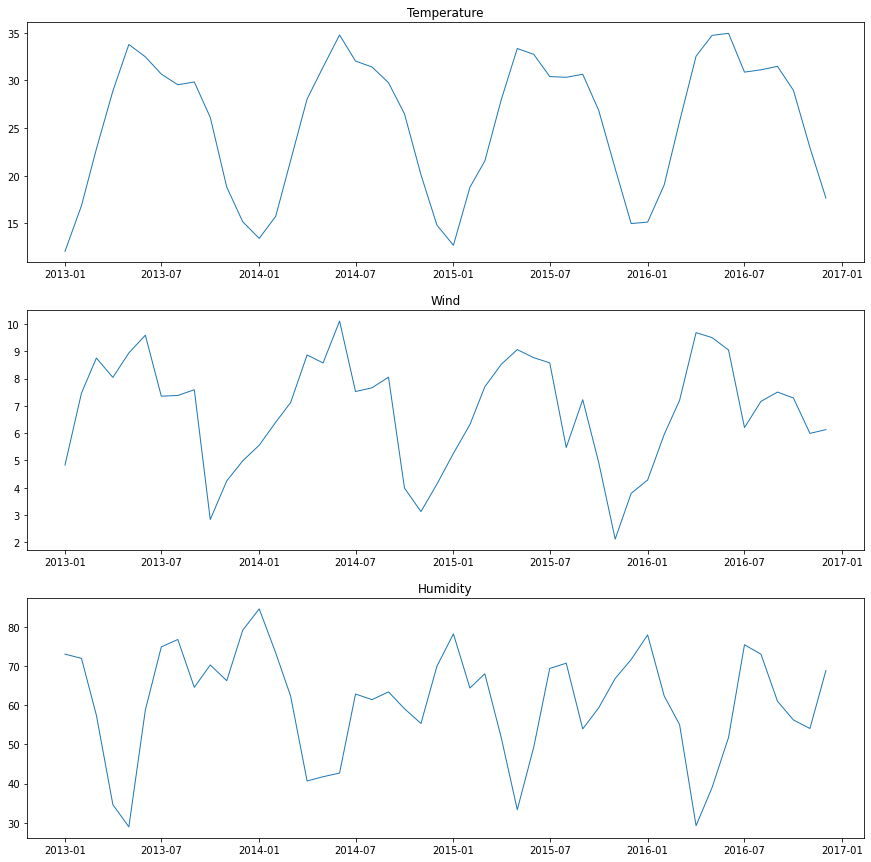

In [14]:
plt.figure(figsize=(15,15))

plt.subplot(3,1,1)
plt.title('Temperature')
plt.plot(dfTrainMS[['meantemp']], linewidth = 1)

plt.subplot(3,1,2)
plt.title('Wind')
plt.plot(dfTrainMS[['wind_speed']], linewidth = 1)

plt.subplot(3,1,3)
plt.title('Humidity')
plt.plot(dfTrainMS[['humidity']], linewidth = 1)

plt.show()

### Stationarity Test

In [15]:
def adf_test(ts, signif=0.05):
    dftest = adfuller(ts, autolag='AIC')
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)
    
    p = adf['p-value']
    if p <= signif:
        print(f" Series is Stationary")
    else:
        print(f" Series is Non-Stationary")

In [16]:
print('Temperature\n')
adf_test(dfTrainMS[['meantemp']])
print('\nWind Speed\n')
adf_test(dfTrainMS[['wind_speed']])
print('\nHumidity\n')
adf_test(dfTrainMS[['humidity']])

Temperature

Test Statistic           0.291903
p-value                  0.976970
# Lags                  10.000000
# Observations          37.000000
Critical Value (1%)     -3.620918
Critical Value (5%)     -2.943539
Critical Value (10%)    -2.610400
dtype: float64
 Series is Non-Stationary

Wind Speed

Test Statistic          -5.288018
p-value                  0.000006
# Lags                   5.000000
# Observations          42.000000
Critical Value (1%)     -3.596636
Critical Value (5%)     -2.933297
Critical Value (10%)    -2.604991
dtype: float64
 Series is Stationary

Humidity

Test Statistic          -5.425196
p-value                  0.000003
# Lags                   7.000000
# Observations          40.000000
Critical Value (1%)     -3.605565
Critical Value (5%)     -2.937069
Critical Value (10%)    -2.606986
dtype: float64
 Series is Stationary


### Differencing

In [17]:
differencedTrainMS = dfTrainMS.diff()

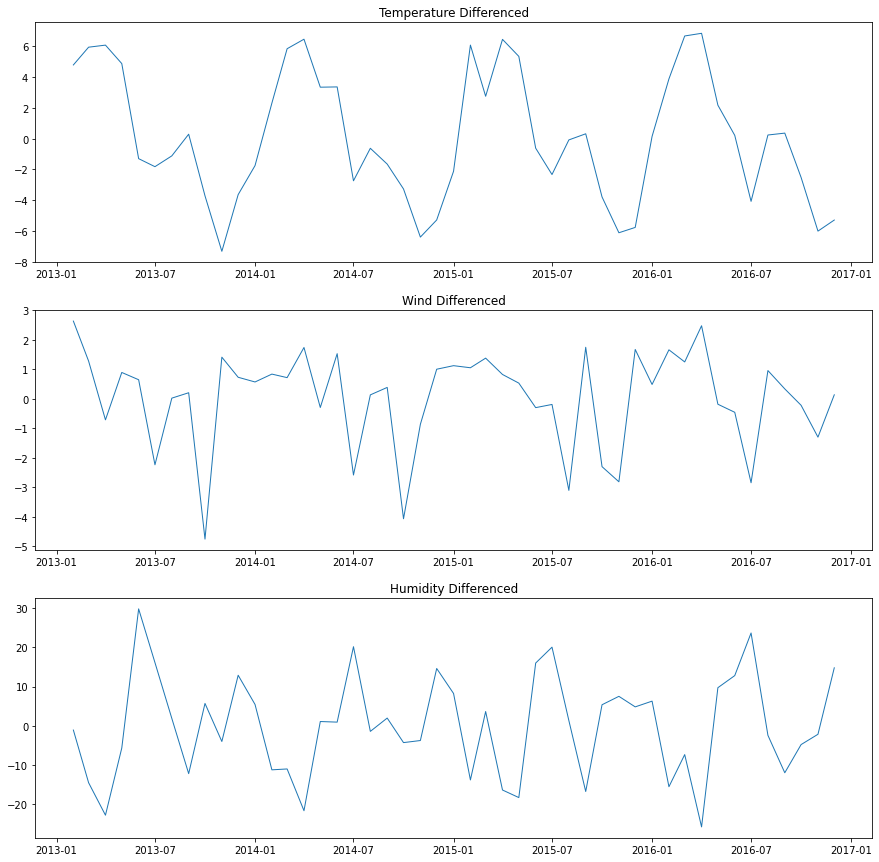

In [18]:
plt.figure(figsize=(15,15))

plt.subplot(3,1,1)
plt.title('Temperature Differenced')
plt.plot(differencedTrainMS[['meantemp']], linewidth = 1)

plt.subplot(3,1,2)
plt.title('Wind Differenced')
plt.plot(differencedTrainMS[['wind_speed']], linewidth = 1)

plt.subplot(3,1,3)
plt.title('Humidity Differenced')
plt.plot(differencedTrainMS[['humidity']], linewidth = 1)

plt.show()

### Check NULLS

In [19]:
differencedTrainMS = differencedTrainMS.dropna(how='all')

In [20]:
differencedTrainMS = differencedTrainMS.drop(columns=['meanpressure'])

In [21]:
differencedTrainMS.isnull().sum()

meantemp      0
humidity      0
wind_speed    0
dtype: int64

### VAR

In [22]:
testModel = None
testModel = VAR(differencedTrainMS)

In [23]:
results = testModel.fit(ic='aic')

In [24]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 20, Apr, 2021
Time:                     20:33:56
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    7.64746
Nobs:                     37.0000    HQIC:                   5.02588
Log likelihood:          -131.072    FPE:                    348.839
AIC:                      3.59839    Det(Omega_mle):         56.1958
--------------------------------------------------------------------
Results for equation meantemp
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.309407         0.259314            1.193           0.233
L1.meantemp           -0.090609         0.728722           -0.124           0.901
L1.humidity            0.113066         0.108479     

In [25]:
prediction = results.forecast(results.y, steps = len(dfTestMS))



D:\Software\Anaconda3\envs\MachineLearning\lib\site-packages\statsmodels\base\wrapper.py:34: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


In [26]:
diffPredDF = pd.DataFrame(prediction, columns=['meantemp', 'humidity', 'wind_speed'])



### Invert Differencing

In [27]:
predDF = pd.DataFrame(columns=['meantemp', 'humidity', 'wind_speed'], index=dfTestMS.index)



In [28]:
predDF['meantemp'] = np.r_[dfTrainMS[-1:]['meantemp'][0], diffPredDF['meantemp']].cumsum()[1:]
predDF['humidity'] = np.r_[dfTrainMS[-1:]['humidity'][0], diffPredDF['humidity']].cumsum()[1:]
predDF['wind_speed'] = np.r_[dfTrainMS[-1:]['wind_speed'][0], diffPredDF['wind_speed']].cumsum()[1:]




### Plot

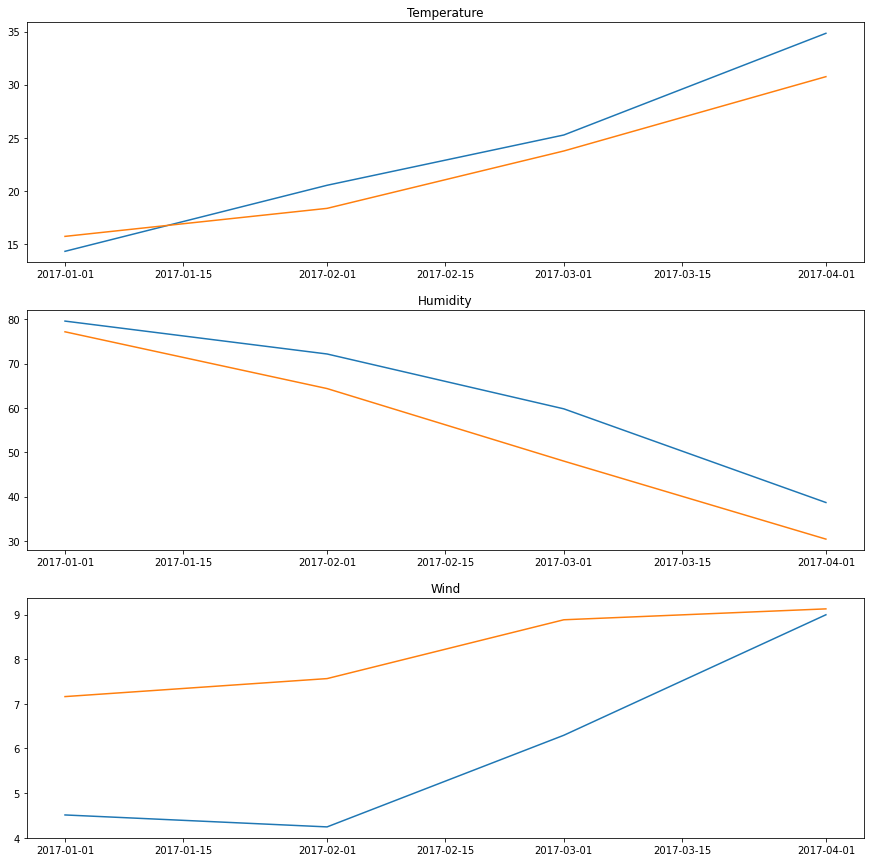

In [29]:
plt.figure(figsize=(15,15))

plt.subplot(3,1,1)
# plt.plot(dfTrain['meantemp'])
plt.plot(predDF['meantemp'])
plt.plot(dfTestMS['meantemp'])
plt.title('Temperature')

plt.subplot(3,1,2)
# plt.plot(dfTrain['humidity'])
plt.plot(predDF['humidity'])
plt.plot(dfTestMS['humidity'])
plt.title('Humidity')

plt.subplot(3,1,3)
# plt.plot(dfTrain['wind_speed'])
plt.plot(predDF['wind_speed'])
plt.plot(dfTestMS['wind_speed'])
plt.title('Wind')

plt.show()

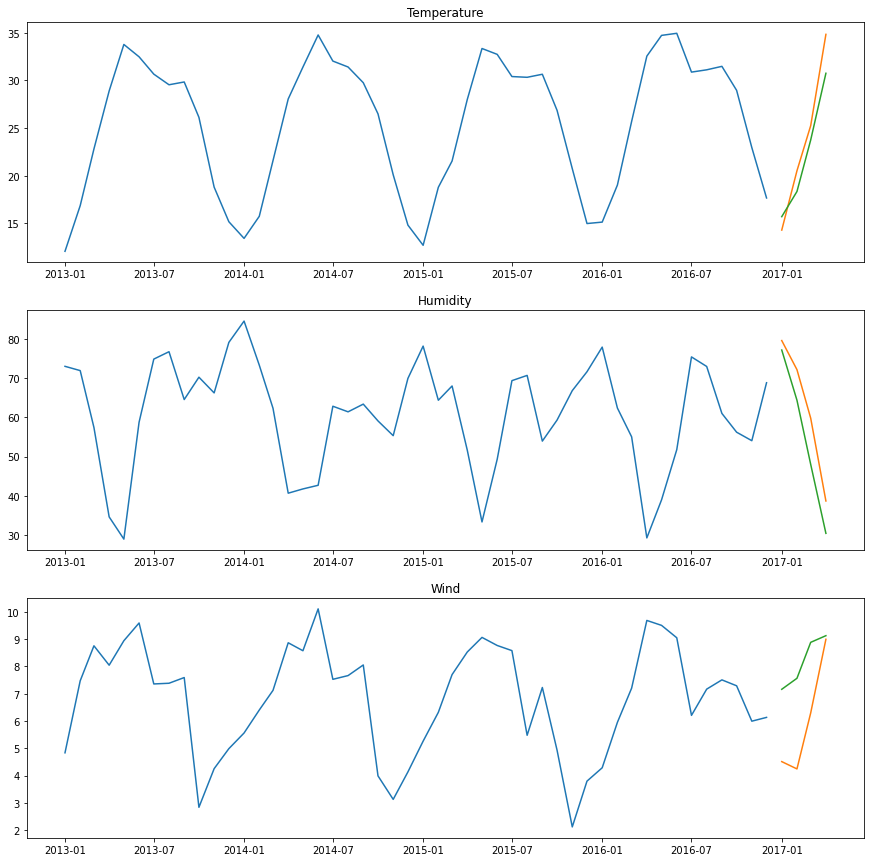

In [30]:
plt.figure(figsize=(15,15))

plt.subplot(3,1,1)
plt.plot(dfTrainMS['meantemp'])
plt.plot(predDF['meantemp'])
plt.plot(dfTestMS['meantemp'])
plt.title('Temperature')

plt.subplot(3,1,2)
plt.plot(dfTrainMS['humidity'])
plt.plot(predDF['humidity'])
plt.plot(dfTestMS['humidity'])
plt.title('Humidity')

plt.subplot(3,1,3)
plt.plot(dfTrainMS['wind_speed'])
plt.plot(predDF['wind_speed'])
plt.plot(dfTestMS['wind_speed'])
plt.title('Wind')

plt.show()

In [31]:
testPred = results.forecast(results.y, steps = len(dfTestMS)*10)
testDiffPredDF = pd.DataFrame(testPred, columns=['meantemp', 'humidity', 'wind_speed'])
testPredDF = pd.DataFrame(columns=['meantemp', 'humidity', 'wind_speed'])

testPredDF['meantemp'] = np.r_[dfTrainMS[-1:]['meantemp'][0], testDiffPredDF['meantemp']].cumsum()[1:]
testPredDF['humidity'] = np.r_[dfTrainMS[-1:]['humidity'][0], testDiffPredDF['humidity']].cumsum()[1:]
testPredDF['wind_speed'] = np.r_[dfTrainMS[-1:]['wind_speed'][0], testDiffPredDF['wind_speed']].cumsum()[1:]

In [32]:
predRange = pd.date_range("2017-01-01", periods=40, freq="MS")

In [33]:
testPredDF.index = predRange

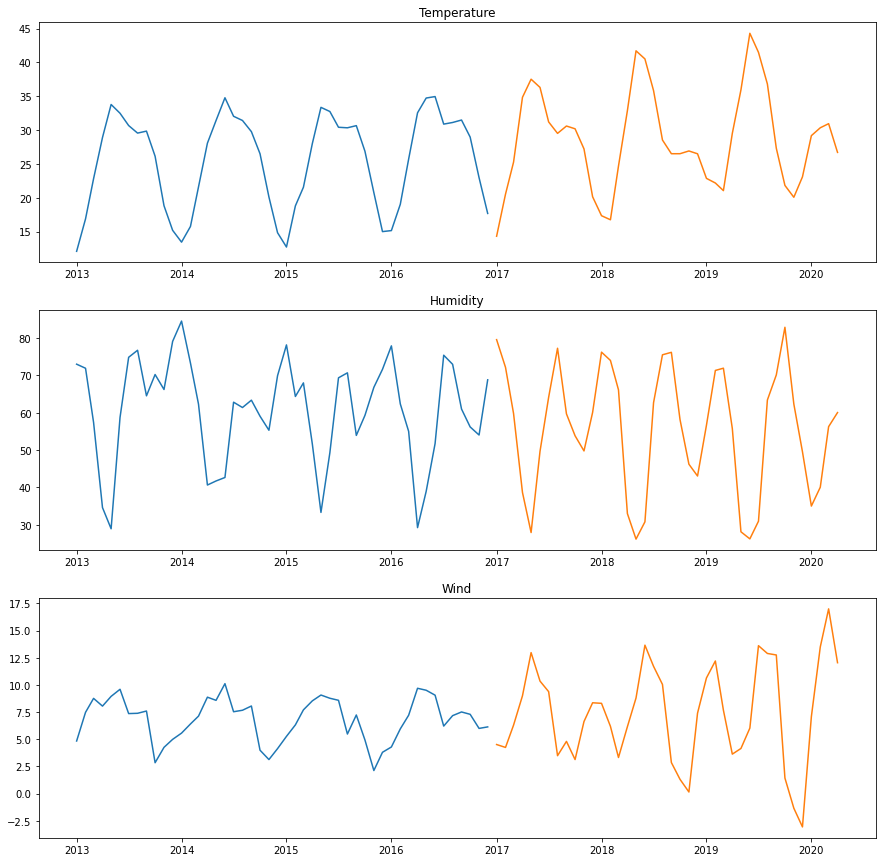

In [34]:
plt.figure(figsize=(15,15))

plt.subplot(3,1,1)
plt.plot(dfTrainMS['meantemp'])
plt.plot(testPredDF['meantemp'])
plt.title('Temperature')

plt.subplot(3,1,2)
plt.plot(dfTrainMS['humidity'])
plt.plot(testPredDF['humidity'])
plt.title('Humidity')

plt.subplot(3,1,3)
plt.plot(dfTrainMS['wind_speed'])
plt.plot(testPredDF['wind_speed'])
plt.title('Wind')

plt.show()

In [35]:
model = None
model = VARMAX(differencedTrainMS, order=(5, 5))
model_result = model.fit(maxiter=1000, disp=False)
model_result.summary()

D:\Software\Anaconda3\envs\MachineLearning\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
D:\Software\Anaconda3\envs\MachineLearning\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Dep. Variable:,"['meantemp', 'humidity', 'wind_speed']",No. Observations:,47
Model:,"VARMA(5,5)",Log Likelihood,-199.006
,+ intercept,AIC,596.011
Date:,"Tue, 20 Apr 2021",BIC,779.176
Time:,20:34:24,HQIC,664.937
Sample:,02-01-2013,,
,- 12-01-2016,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.98, 0.00, 3.29",Jarque-Bera (JB):,"1.48, 0.40, 0.55"
Prob(Q):,"0.32, 0.99, 0.07",Prob(JB):,"0.48, 0.82, 0.76"
Heteroskedasticity (H):,"1.41, 0.52, 0.34",Skew:,"-0.13, -0.16, -0.26"


In [36]:
VARMAXdiffPred = model_result.forecast(steps = len(dfTestMS))

VARMAXpredDF = pd.DataFrame(columns=['meantemp', 'humidity', 'wind_speed'], index=dfTestMS.index)

VARMAXpredDF['meantemp'] = np.r_[dfTrainMS[-1:]['meantemp'][0], VARMAXdiffPred['meantemp']].cumsum()[1:]
VARMAXpredDF['humidity'] = np.r_[dfTrainMS[-1:]['humidity'][0], VARMAXdiffPred['humidity']].cumsum()[1:]
VARMAXpredDF['wind_speed'] = np.r_[dfTrainMS[-1:]['wind_speed'][0], VARMAXdiffPred['wind_speed']].cumsum()[1:]

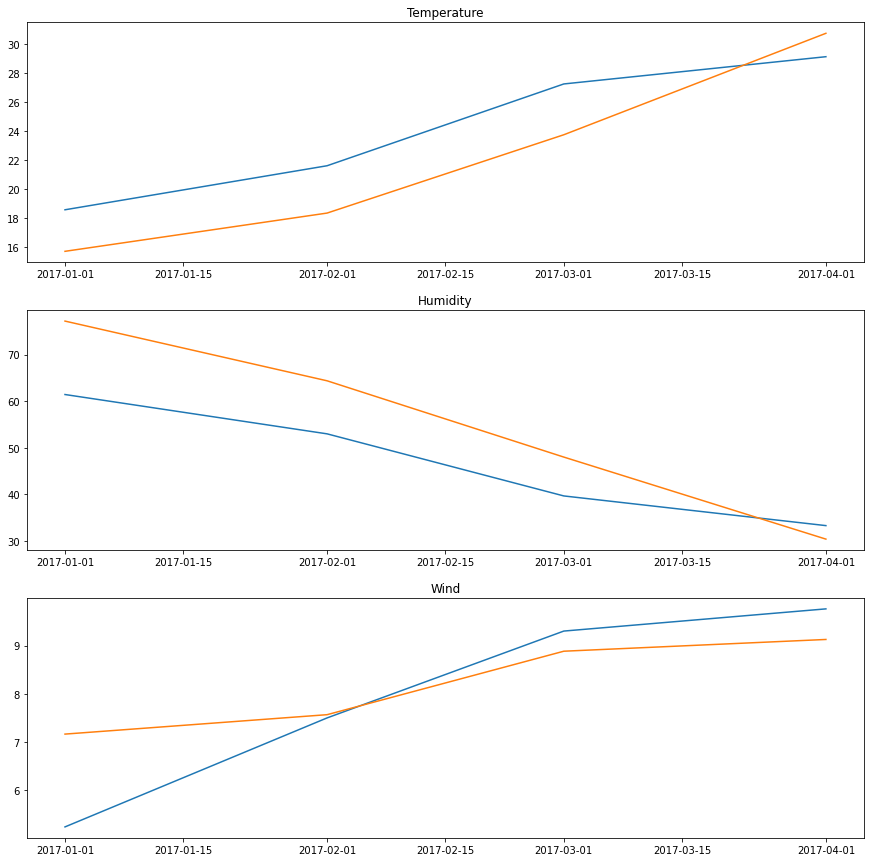

In [37]:
plt.figure(figsize=(15,15))

plt.subplot(3,1,1)
# plt.plot(dfTrain['meantemp'])
plt.plot(VARMAXpredDF['meantemp'])
plt.plot(dfTestMS['meantemp'])
plt.title('Temperature')

plt.subplot(3,1,2)
# plt.plot(dfTrain['humidity'])
plt.plot(VARMAXpredDF['humidity'])
plt.plot(dfTestMS['humidity'])
plt.title('Humidity')

plt.subplot(3,1,3)
# plt.plot(dfTrain['wind_speed'])
plt.plot(VARMAXpredDF['wind_speed'])
plt.plot(dfTestMS['wind_speed'])
plt.title('Wind')

plt.show()